# IMPROVED LSTM ON IMPUTED DATA.

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.5)
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import pickle
import keras
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
import pydot_ng as pydot
from keras.utils import plot_model

Using TensorFlow backend.


## Load the data

In [2]:
df=pd.read_csv('sub1.csv', header=None)

In [3]:
df.columns

Int64Index([0, 1, 2, 3, 4], dtype='int64')

Here, we picked one column to represent the data since they are pretty much alike 

In [4]:
df['2nd']=df[2]

In [5]:
df=df['2nd']

## Feature extraction using timesteps

We are using the previous data values to determine the next one. 

so the value at (t-1)s will be used to determine value at (t)s

we are employing 12 timesteps, so the previous 12 values will be used to determine the 13th values.

In [6]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

### Normalisation

Normalisation-this helps the model work better as they dont understand the context of the
 data, ages of people and heights of people are different context which the model cant understand.
 normalisation gives the values a particular to help the model understand the limits and 
 context of the data.

In [7]:
dataset = df.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

we also performed some splitting activities to divide the data so we can test the model with a data that it has not seen.

In [8]:
look_back = 12
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

### 2D to 3D

LSTM input layer requires a 3D data. In DNN, 2D data was used as [samples,features]. it assumes the timesteps are the features but LSTM takes the timesteps into consideration. so the 3D data will now be [samples, time steps, features]

In [9]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Improved LSTM Model

In [10]:
model = Sequential() 
model.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(Dense(1)) 
model.compile(loss='mean_squared_error', optimizer='adam')


history = model.fit(X_train, Y_train, epochs=20, batch_size=100, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 1514347 samples, validate on 378577 samples
Epoch 1/20
1514347/1514347 [==============================] - 105s 69us/step - loss: 4.8655e-04 - val_loss: 1.8697e-04
Epoch 2/20
1514347/1514347 [==============================] - 104s 69us/step - loss: 3.0493e-04 - val_loss: 1.7845e-04
Epoch 3/20
1514347/1514347 [==============================] - 98s 65us/step - loss: 3.0288e-04 - val_loss: 1.7677e-04
Epoch 4/20
1514347/1514347 [==============================] - 105s 69us/step - loss: 3.0134e-04 - val_loss: 1.7690e-04
Epoch 5/20
1514347/1514347 [==============================] - 104s 69us/step - loss: 2.9991e-04 - val_loss: 1.7830e-04
Epoch 6/20
1514347/1514347 [==============================] - 100s 66us/step - loss: 2.9804e-04 - val_loss: 1.7348e-04
Epoch 7/20
1514347/1514347 [==============================] - 101s 67us/step - loss: 2.9628e-04 - val_loss: 1.7181e-04
Epoch 8/20
1514347/1514347 [==============================] - 98s 65us/step - loss: 2.9508e-04 - val_loss: 1.7298e-

### Prediction

### Error evaluation

In [12]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.6693718925983583
Train Root Mean Squared Error: 2.8035697052921686
Test Mean Absolute Error: 0.4049836446801417
Test Root Mean Squared Error: 2.1634720026769116


### Model losses when training the model and testing

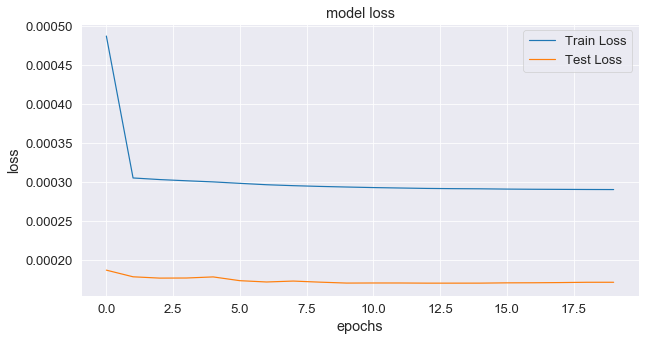

In [13]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

### Actual values vs Predicted values

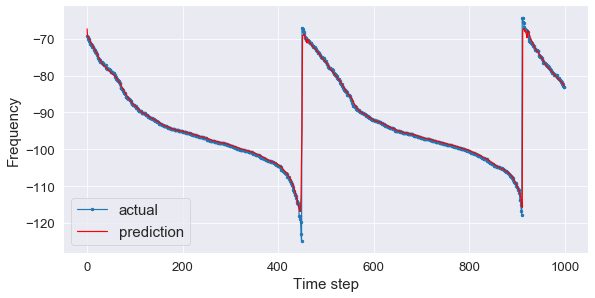

In [14]:
aa=[x for x in range(1000)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_train[0][:1000], marker='.', label="actual")
plt.plot(aa, train_predict[:,0][:1000], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Frequency', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

### Saving predicted data

In [15]:
sed=pd.DataFrame(test_predict)
sed.to_csv('imputedLSTMpredict.csv', index=False)

### Saving the model 

In [17]:
filename = 'imputed_model_LSTM.sav'
pickle.dump(model, open(filename, 'wb'))

In [18]:
model_json = model.to_json()
with open("imputedLSTM_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


### Saving the normalisation model

the LSTM model was built on normalised data for better result. When attempting to predict new values, the data must be normalised before being sent to the model  

In [19]:
filename = 'imputed_LSTMscaler.sav'
pickle.dump(scaler, open(filename, 'wb'))

### Loading the saved model

In [20]:
json_file = open('imputedLSTM_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [21]:
look_back = 12
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
train_predict = loaded_model.predict(X_train)
test_predict = loaded_model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.6693718925983583
Train Root Mean Squared Error: 2.8035697052921686
Test Mean Absolute Error: 0.4049836446801417
Test Root Mean Squared Error: 2.1634720026769116


### Visualisation of the Neural Network

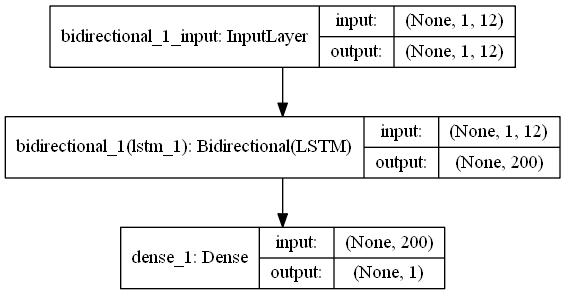

In [22]:
plot_model(model, to_file='imputedLSTM.png', show_shapes=True)